In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import sys
import math
from itertools import permutations
import VRPSolverEasy as vrpse
import csv
import random

In [2]:
#Tabela das origens de destinos
path = '/Users/TullioPires/Python-Mestrado/Problema Celio/celio-problema.csv'
celio = pd.read_csv(path, index_col=[0,1], squeeze=True)

#Pivotar a tabela, para ler
pivoted_celio = celio.reset_index().pivot(index = 'Origem', columns = 'Destino', values = 'Distancia')
pivoted_celio

/var/folders/f8/sx2sm28s5xn92g54_n5vypwh0000gn/T/ipykernel_49948/789512513.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  celio = pd.read_csv(path, index_col=[0,1], squeeze=True)


Destino,0,1,2,3,4,5,6,7,8,9
Origem,,,,,,,,,,
0,500,76,39,50,56,63,77,85,119,86
1,76,500,53,54,66,45,23,20,59,14
2,39,59,500,17,10,18,45,52,105,60
3,48,59,17,500,10,18,45,52,105,60
4,54,72,23,10,500,25,58,65,118,73
5,59,53,28,18,25,500,26,36,99,36
6,69,39,38,39,52,30,500,12,86,41
7,79,20,48,49,62,40,12,500,75,28
8,113,56,101,102,115,93,71,72,500,54


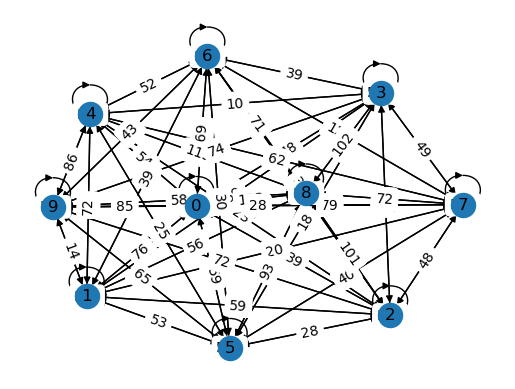

In [3]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for i, row in pivoted_celio.iterrows():
    for j, distance in row.items():
        if not pd.isna(distance):
            G.add_edge(str(i), str(j), weight=distance)

# Set positions for each node
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

# Draw edge labels (distances)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.axis('off')
plt.show()

In [4]:
#Criando o modelo do Célio
modelo_celio_VRP = vrpse.Model()

In [5]:
#Lendo as distancais

distances = {}
with open(path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        origin = int(row['Origem'])
        destination = int(row['Destino'])
        distance = int(row['Distancia'])
        distances[(origin, destination)] = distance
        
#Mostrando as distancias como dicionário
for (origin, destination), distance in distances.items():
    print(f"Distance from {origin} to {destination}: {distance}")

Distance from 0 to 0: 500
Distance from 0 to 1: 76
Distance from 0 to 2: 39
Distance from 0 to 3: 50
Distance from 0 to 4: 56
Distance from 0 to 5: 63
Distance from 0 to 6: 77
Distance from 0 to 7: 85
Distance from 0 to 8: 119
Distance from 0 to 9: 86
Distance from 1 to 0: 76
Distance from 1 to 1: 500
Distance from 1 to 2: 53
Distance from 1 to 3: 54
Distance from 1 to 4: 66
Distance from 1 to 5: 45
Distance from 1 to 6: 23
Distance from 1 to 7: 20
Distance from 1 to 8: 59
Distance from 1 to 9: 14
Distance from 2 to 0: 39
Distance from 2 to 1: 59
Distance from 2 to 2: 500
Distance from 2 to 3: 17
Distance from 2 to 4: 10
Distance from 2 to 5: 18
Distance from 2 to 6: 45
Distance from 2 to 7: 52
Distance from 2 to 8: 105
Distance from 2 to 9: 60
Distance from 3 to 0: 48
Distance from 3 to 1: 59
Distance from 3 to 2: 17
Distance from 3 to 3: 500
Distance from 3 to 4: 10
Distance from 3 to 5: 18
Distance from 3 to 6: 45
Distance from 3 to 7: 52
Distance from 3 to 8: 105
Distance from 3 to

In [6]:
# Dados
cost_per_distance = 10
begin_time = 0
end_time = 360
nb_point = 10

In [7]:
#Geração das demandas

demands_range = (100, 200)

demands = {}
for i in range(1, nb_point):
    demand = random.randint(*demands_range)
    demands[i] = 0
    
# Print the capacities
for node, demand in demands.items():
    print(f"Node {node}: Demand = {demand}")

Node 1: Demand = 0
Node 2: Demand = 0
Node 3: Demand = 0
Node 4: Demand = 0
Node 5: Demand = 0
Node 6: Demand = 0
Node 7: Demand = 0
Node 8: Demand = 0
Node 9: Demand = 0


In [8]:
# Adicionando o tipo de veículo
modelo_celio_VRP.add_vehicle_type(
    id=1,
    start_point_id=0,
    end_point_id=0,
    name="VEH1",
    capacity=1,
    max_number=3,
    var_cost_dist=cost_per_distance,
    tw_end=end_time)

In [9]:
# Adicionando a base
modelo_celio_VRP.add_depot(id=0, name="base", tw_begin=0, tw_end=end_time)

In [10]:
# Adicionando os demais nós
for i in range(1, nb_point):
    modelo_celio_VRP.add_customer(
        id=i,
        name=f"C{i}",
        demand=demands[i],
        tw_begin=begin_time,
        tw_end=end_time
    )

In [11]:
# Adicionando ligações do depot aos demais nós - plano B
for i in range(1, nb_point):
    distance = distances[(0, i)]
    modelo_celio_VRP.add_link(
        start_point_id=1,
        end_point_id=i,
        is_directed = True,
        distance=distance,
        time=distance,
    )

In [12]:
# Add links
for i in range(0, nb_point):
    for j in range(0, nb_point):
        if i!=j:
            dist = distances[i,j]
            modelo_celio_VRP.add_link(start_point_id=i,end_point_id=j,distance=dist,time=dist + 30)

In [13]:
# Resolvendo o modelo
modelo_celio_VRP.solve()
modelo_celio_VRP.export()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
VRPSolver v0.5.28, 16/03/2023, © Inria Bordeaux, France, vrpsolver.math.u-bordeaux.fr
      Corresponds to the solver by Pessoa, Sadykov, Uchoa and Vanderbeck (2020)
                 Paper: dx.doi.org/10.1007/s10107-020-01523-z
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   BaPCod v0.77, 23/03/2023, © Inria Bordeaux, France, bapcod.math.u-bordeaux.fr 
           THIS CODE IS PROVIDED AS IS, USE IT AT YOUR OWN RISK
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model is built TIME = 0h0m0s0t = 0
************************************************************************************************
**** BaB tree root node
**** Local DB = -1e+12, global bounds : [ -1e+12 , 1e+06 ], TIME = 0h0m0s0t = 0
**** 1 open nodes, 0 columns (0 active), 0 dyn. constrs. (0 active), 20 art. vars. (20 active)
*************************************

In [14]:
print(modelo_celio_VRP.solution)


Solution cost : 5520.0 
 
Route for vehicle 1:
 ID : 0 --> 9 --> 8 --> 0
 Name : base --> C9 --> C8 --> base
 End time : 0.0 --> 115.0 --> 199.0 --> 342.0
Total cost : 2520.0
 
Route for vehicle 1:
 ID : 0 --> 2 --> 4 --> 3 --> 0
 Name : base --> C2 --> C4 --> C3 --> base
 End time : 0.0 --> 69.0 --> 109.0 --> 149.0 --> 227.0
Total cost : 1070.0
 
Route for vehicle 1:
 ID : 0 --> 5 --> 6 --> 7 --> 1 --> 0
 Name : base --> C5 --> C6 --> C7 --> C1 --> base
 End time : 0.0 --> 89.0 --> 145.0 --> 187.0 --> 237.0 --> 343.0
Total cost : 1930.0
 

